In [1]:
from fastai.vision.all import *
from eagle_swing.data_class import *
from eagle_swing.video_utils import *

In [2]:
df = pd.read_csv('test_df.csv')
df.shape

(185, 249)

In [3]:
plt.style.use('dark_background')

In [4]:
df.columns

Index(['peak_shoulder_vel', 'peak_hip_vel', 'peak_x_torque', 'x_factor_at_top',
       'x_factor_10+_top', 'x_factor_-10_top', 'x_factor_20+_top',
       'x_factor_-20_top', 'x_factor_30+_top', 'x_factor_-30_top',
       ...
       'min_vertical_ext', 'max_right_arm_angle', 'max_left_arm_angle',
       'max_right_leg_angle', 'max_left_leg_angle', 'max_right_side_angle',
       'max_left_side_angle', 'shoulder_acc_std', 'clip_name', 'swing_day'],
      dtype='object', length=249)

In [5]:
weird_peak_shoulder_vel = df[df.peak_shoulder_vel > 50].clip_name.values
weird_peak_shoulder_vel

array(['IMG_1093_swing_0_score_1', 'IMG_1087_swing_0_score_4',
       'IMG_1091_swing_4_score_4'], dtype=object)

In [29]:
base_path = '../../../data/full_videos/ymirza'
day_path = f"{base_path}/sep14"
cleaned_df_paths = [file for file in get_files(day_path, extensions='.csv') if file.name == 'clean_lbls.csv']
df_holder = []
for df_path in cleaned_df_paths:
    df_holder.append(pd.read_csv(df_path))
cleaned_df = pd.concat(df_holder).reset_index(drop=True)
#cleaned_df['swing_day'] = cleaned_df.pkl_path.map(lambda x: x.split('/')[0])
print(f"our final data frame has shape: {cleaned_df.shape}")
cleaned_df['pkl_path'] = cleaned_df.pkl_path.map(lambda x: f'{base_path}/{x}')
before_increment = 30
after_increment = 5
cleaned_df['start_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] - before_increment
cleaned_df['end_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] + after_increment

our final data frame has shape: (46, 6)


In [30]:
df5 = cleaned_df[cleaned_df.score.map(lambda x: x == 5)]
df1 = cleaned_df[cleaned_df.score.map(lambda x: x == 1)]
test_df = pd.concat([df5.iloc[:3], df1.iloc[:3]]).reset_index(drop=True)

In [8]:
#test_df = cleaned_df[cleaned_df.clip_name.map(lambda x: x in weird_peak_shoulder_vel)]
# test_df = cleaned_df[cleaned_df.video_name.map(lambda x: x == 'IMG_1093')]
# test_df

In [31]:
frames_list = []
for idx, row in test_df.iterrows():
    video_path = f"{row.pkl_path[:-3]}mp4"
    frames, fps = get_frames(video_path,
                            start_idx=row.start_idx,
                             num_frames=row.end_idx - row.start_idx,
                            )
    frames_list.append(frames)
[x.shape for x in frames_list]

100%|████████████████████| 35/35 [00:00<00:00, 472.45it/s]


[(35, 256, 256, 3),
 (35, 256, 256, 3),
 (35, 256, 256, 3),
 (35, 256, 256, 3),
 (35, 256, 256, 3),
 (35, 256, 256, 3)]

In [32]:
view_videos_grid(frames_list)

In [33]:
SwExt_list = []
for idx, row in test_df.iterrows():
    SwExt_list.append(SwingExtractor(row))
clip_names = [SwExt_list[x].clip_name for x in range(len(SwExt_list))]
print(clip_names)

['IMG_1086_swing_3_score_5', 'IMG_1086_swing_4_score_5', 'IMG_1087_swing_1_score_5', 'IMG_1093_swing_0_score_1', 'IMG_1093_swing_2_score_1', 'IMG_1093_swing_4_score_1']


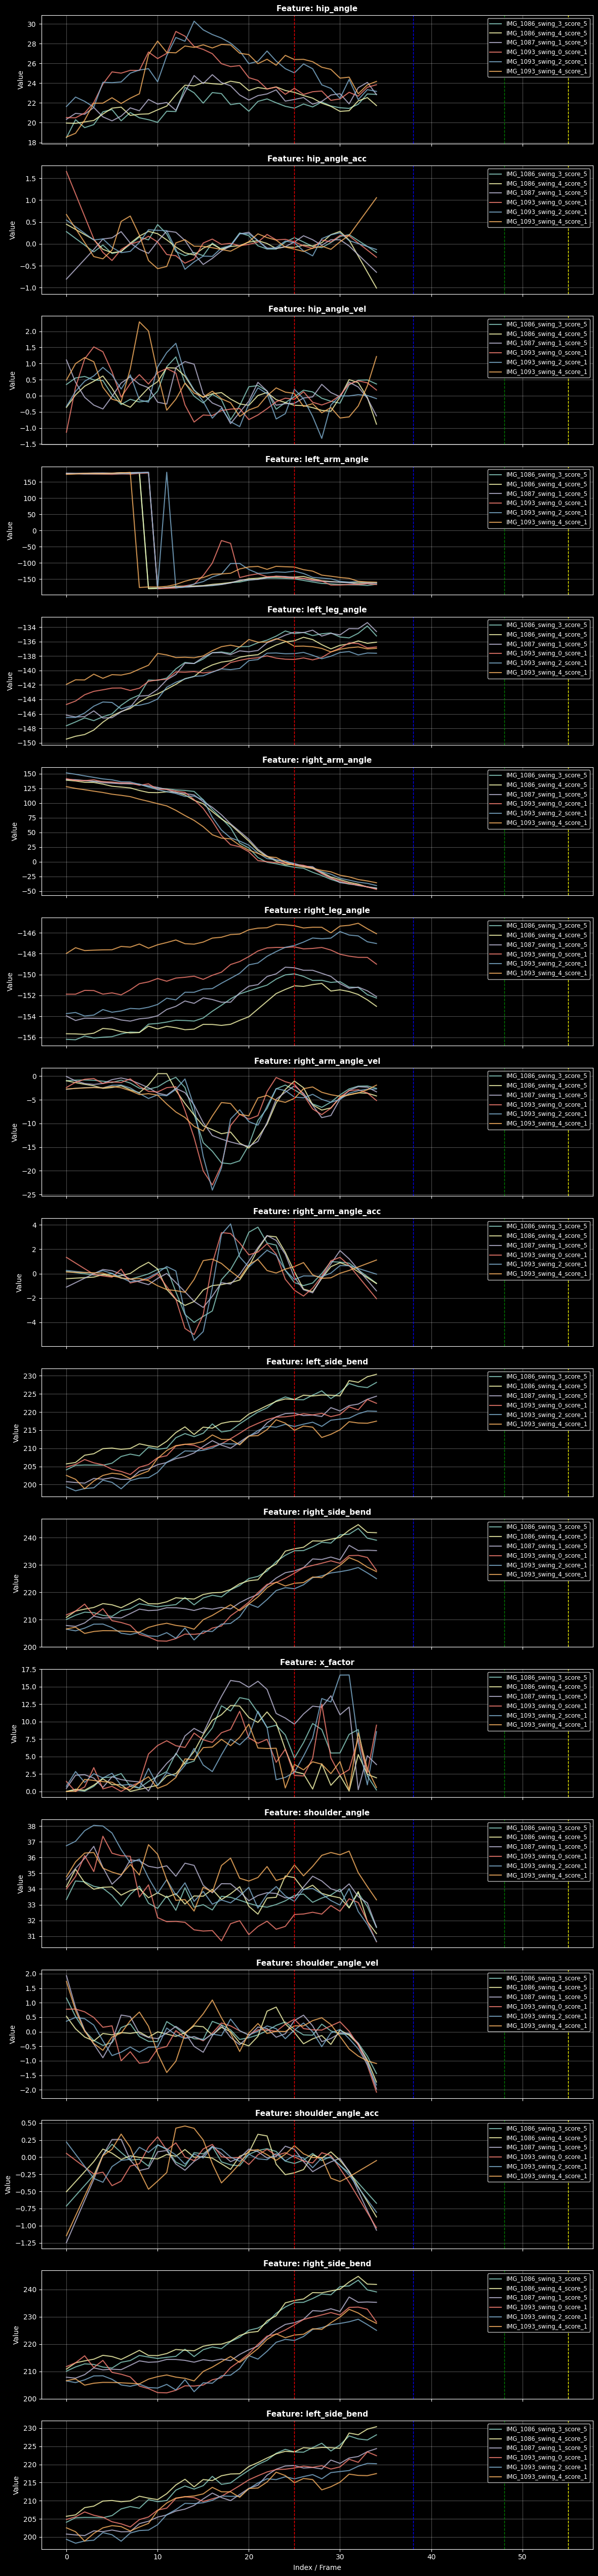

In [36]:
plot_feature_comparison(
    SwExt_list, 
    'hip_angle',
    'hip_angle_acc',
    'hip_angle_vel',
    'left_arm_angle',
    'left_leg_angle',
    'right_arm_angle',
    'right_leg_angle',
    'right_arm_angle_vel',
    'right_arm_angle_acc',
    'left_side_bend',
    'right_side_bend',
    'x_factor',
    'shoulder_angle',
    'shoulder_angle_vel',
    'shoulder_angle_acc',
    'right_side_bend',
    'left_side_bend',
    # 'vertical_extension',
    # 'vertical_extension_vel',
    # 'vertical_extension_acc',
    # 'x_factor',
    # 'x_factor_vel',
    # 'x_factor_acc',
    # 'x_torque',
    
    #attr_name='metrics',
    instance_labels=clip_names,
    markers=[25, 38, 48, 55],
)

In [35]:
def plot_feature_comparison(instances, *features, attr_name='data',
                            instance_labels=None, figsize=None,
                            markers=None,
                            marker_kwargs=None,
                            legend_side='right'):
    """
    Plots specified features vertically, comparing multiple class instances on each plot.
    
    Args:
        instances (list): List of 2-6 class instances.
        *features (str): Variable number of feature names (keys) to extract from the attribute.
        attr_name (str): The name of the attribute to index into (default: 'data').
                         e.g., if you access instance.metrics['velocity'], attr_name='metrics'.
        instance_labels (list, optional): List of strings to label the instances in the legend.
        figsize (tuple, optional): Figure size override. Defaults to auto-scaled height.
    """
    num_features = len(features)
    if num_features == 0:  
        print("No features provided to plot.")
        return

    # Set up the vertical subplot layout
    # Dynamically scale height: 3 inches per feature is usually a good readable standard
    fig_height = 3 * num_features
    if figsize is None:
        figsize = (12, fig_height)
        
    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=figsize, sharex=True)
    
    # Ensure axes is iterable even if there's only one feature
    if num_features == 1:
        axes = [axes]
        
    # Generate default labels if none provided
    if instance_labels is None:
        instance_labels = [f"Instance {i+1}" for i in range(len(instances))]
    if marker_kwargs is None:
        colors = ['red', 'blue', 'green', 'yellow']
        marker_kwargs = [dict(color=colors[x], linestyle='--', linewidth=1) for x in range(len(colors))]
    # Loop through each feature (subplot)
    for ax, feature in zip(axes, features):
        ax.set_title(f"Feature: {feature}", fontsize=11, fontweight='bold')
        ax.set_ylabel("Value")
        2
        # Loop through each class instance (line in the plot)
        for i, instance in enumerate(instances):
            try:
                # 1. Access the attribute (e.g., instance.data)
                #container = instance#getattr(instance, attr_name)
                # 2. Index into the attribute (e.g., instance.data['velocity'])
                data_array = getattr(instance, feature)
                #print(data_array.shape){
                
                # Plotting logic
                ax.plot(data_array, label=instance_labels[i], alpha=0.8, linewidth=1.5)
                
            except KeyError:
                print(f"Warning: Feature '{feature}' not found in instance {i+1}.")
            #except AttributeError:
            #    print(f"Error: Instance {i+1} does not have attribute '{attr_name}'.")
                # add vertical marker on this subplot
        if markers:
            if type(markers) == list:
                [ax.axvline(marker, **marker_kwargs[idx]) for idx, marker in enumerate(markers)]
            else: 
                ax.axvline(markers, **marker_kwargs)
            
        ax.grid(True, alpha=0.3)
        ax.legend(loc=f'upper {legend_side}', fontsize='small', framealpha=0.9)

    # Label the bottom x-axis only
    axes[-1].set_xlabel("Index / Frame")
    
    plt.tight_layout()
    plt.show()


In [ ]:
#SwExt_list[0].kps.kps

IMG_1086_swing_3_score_5


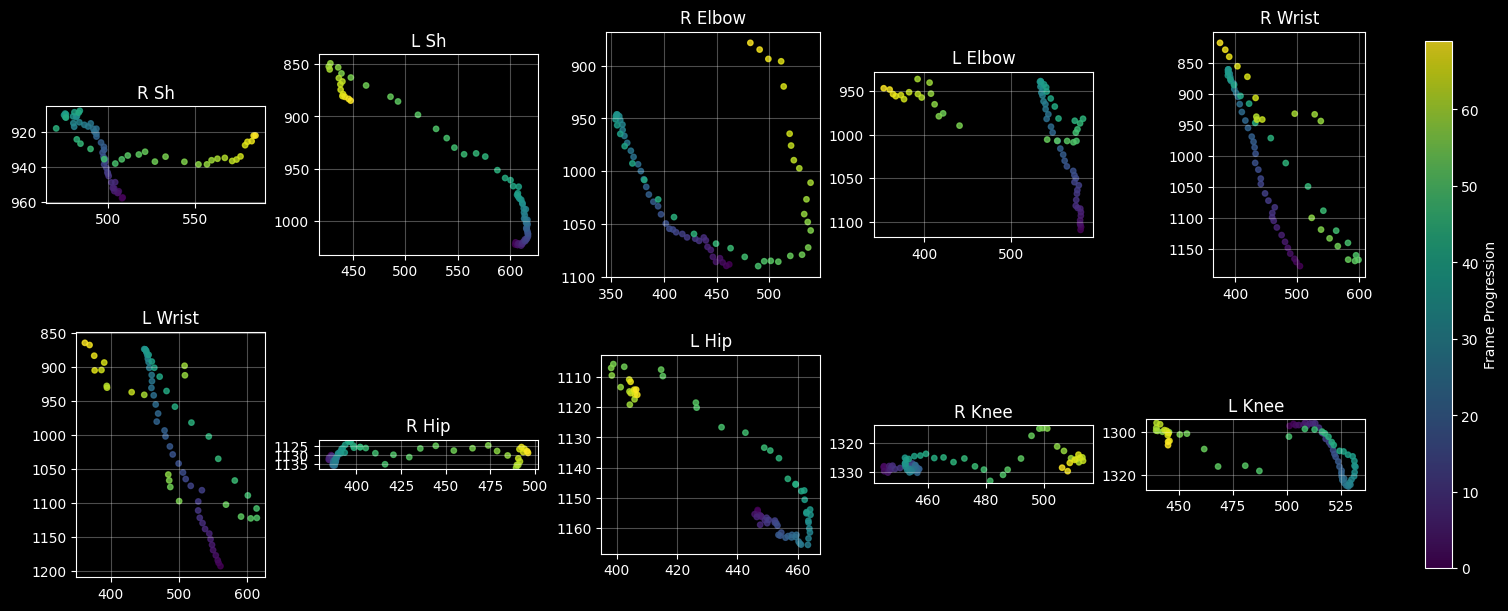

In [20]:
print(SwExt_list[0].clip_name)
plot_feature_trajectories(SwExt_list[0].kps)

IMG_1093_swing_2_score_1


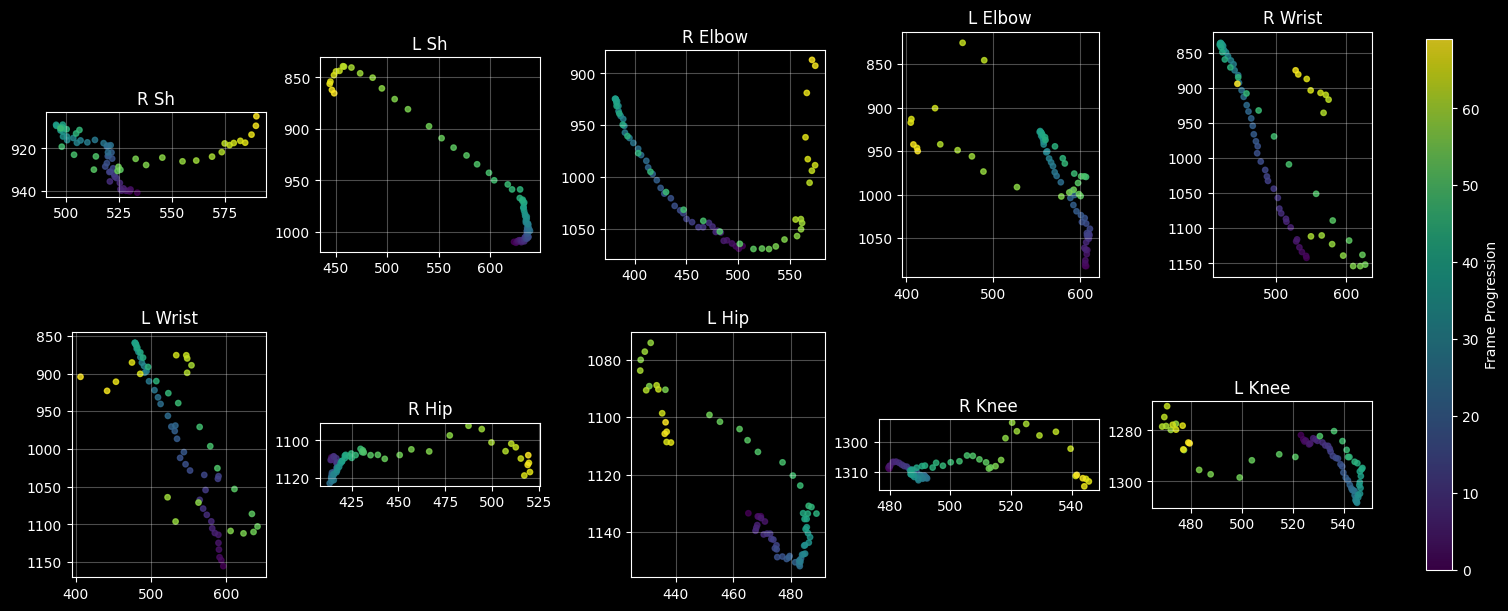

In [21]:
print(SwExt_list[4].clip_name)
plot_feature_trajectories(SwExt_list[4].kps)

In [25]:
def plot_feature_trajectories(data_instance, 
                              feature_names=None, 
                              figsize=(15, 6)):
    """
    Plots trajectories for specific attributes retrieved from a class instance.
    
    Args:
        data_instance: The class instance containing the data as attributes.
        feature_names (list of str): List of attribute names (e.g., ['r_wrist', 'hip_center']).
                                     Each attribute should return a numpy array of shape (Frames, 2).
        figsize (tuple): Dimensions of the entire figure.
    """
    if feature_names is None:
        feature_names = ['r_sh', 'l_sh', 
                         'r_elbow', 'l_elbow', 
                         'r_wrist', 'l_wrist', 
                         'r_hip', 'l_hip', 
                         'r_knee', 'l_knee', 
                         #'r_ankle', 'l_ankle'
                        ]
    # 1. Setup Grid
    num_plots = len(feature_names)
    cols = 5
    rows = int(np.ceil(num_plots / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes_flat = axes.flatten()
    
    # 2. Loop through feature names
    # We define the color mapper inside the loop or based on the first valid item
    # to ensure it matches the frame count of the data.
    
    first_valid_plot = None
    
    for i, name in enumerate(feature_names):
        if i >= len(axes_flat): break
        ax = axes_flat[i]
        
        # --- KEY CHANGE: Dynamic Retrieval ---
        try:
            data = getattr(data_instance, name)
        except AttributeError:
            ax.text(0.5, 0.5, f"Attribute '{name}'\nnot found", 
                    ha='center', va='center', transform=ax.transAxes)
            continue
            
        # Robust check for data shape
        # Expecting (Frames, 2) or (Frames, 1, 2)
        if data.ndim == 3 and data.shape[1] == 1:
            data = data.squeeze(1) # Convert (N, 1, 2) -> (N, 2)
            
        if data.ndim != 2 or data.shape[1] < 2:
            ax.text(0.5, 0.5, f"Invalid Shape\n{data.shape}", 
                    ha='center', va='center')
            continue

        # Extract coordinates
        x = data[:, 0]
        y = data[:, 1]
        
        # Create Time Colors (based on length of this specific array)
        time_colors = np.arange(len(x))
        
        # Plot
        sc = ax.scatter(x, y, c=time_colors, cmap='viridis', s=15, alpha=0.8)
        
        # --- KEY CHANGE: Labeling ---
        ax.set_title(name.replace('_', ' ').title()) # e.g., "r_wrist" -> "R Wrist"
        
        # Standard CV Formatting
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        if first_valid_plot is None:
            first_valid_plot = sc

    # 3. Hide unused subplots
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')

    # 4. Add Colorbar (referenced to the first valid plot found)
    if first_valid_plot:
        cbar = fig.colorbar(first_valid_plot, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('Frame Progression')
    
    plt.show()

# --- Example Usage ---

# Mock Class mimicking your setup
class SwingAnalysis:
    def __init__(self):
        # Create dummy trajectories (Frames=50, xy=2)
        frames = 50
        t = np.linspace(0, 3, frames)
        
        # Attribute 1: Right Wrist (Circular motion)
        self.r_wrist = np.column_stack([
            100 + 20 * np.cos(t), 
            100 + 20 * np.sin(t)
        ])
        
        # Attribute 2: Left Ankle (Linear motion with noise)
        self.l_ankle = np.column_stack([
            50 + t * 10, 
            200 + np.random.randn(frames) * 2
        ])

In [24]:
def plot_keypoint_trajectories(keypoints, indices=range(6, 16), figsize=(15, 6)):
    """
    Plots the trajectory of specific keypoints in a grid.
    
    Args:
        keypoints (np.array): Shape (Frames, Num_Keypoints, 2) or (Frames, Num_Keypoints, 3)
        indices (iterable): List of keypoint indices to plot (e.g., 6-15).
        figsize (tuple): Figure dimensions.
    """
    # 1. Setup the Grid
    num_plots = len(indices)
    cols = 5
    rows = int(np.ceil(num_plots / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes_flat = axes.flatten()
    
    # 2. Setup Time/Color Mapping
    num_frames = keypoints.shape[0]
    time_colors = np.arange(num_frames) # Linear array [0, 1, ..., N]
    
    # 3. Loop and Plot
    for i, kp_idx in enumerate(indices):
        if i >= len(axes_flat): break
        ax = axes_flat[i]
        
        # Extract X and Y for this keypoint across all frames
        # Assuming shape (Frames, KPs, Coords)
        x = keypoints[:, kp_idx, 0]
        y = keypoints[:, kp_idx, 1]
        
        # Plot trajectory: color (c) changes with time index
        sc = ax.scatter(x, y, c=time_colors, cmap='viridis', s=10, alpha=0.8)
        
        # Formatting
        ax.set_title(f"KP Index: {kp_idx}")
        ax.invert_yaxis()    # Important for image coordinates (0,0 at top-left)
        ax.set_aspect('equal') # Prevents distortion of motion path
        ax.grid(True, alpha=0.3)

    # 4. Hide unused subplots if any
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')

    # 5. Add Shared Colorbar
    cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Frame Progression')
    
    plt.show()